In [ ]:
# General comments and considerations

In [197]:
# general stuff
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import os,re
import time
import nibabel as nib
from subprocess import Popen, PIPE

# sklearn stuff
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import scale
import sklearn.metrics.cluster as metrics
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster.hierarchical import _hc_cut # Internal function to cut ward tree, helps speed up things a lot
from sklearn.utils import resample
from sklearn.model_selection import KFold

# personal functions
from importlib import reload
import myutils as mu
reload(mu)

# atlas_root='/data1/vbeliveau/atlas'
# cluster_root=atlas_root + '/analyses/clustering'
# info_path=atlas_root + '/lists/info_alltracers_base_healthy_hrrt.mat'

# At NRU
# cluster_code='/data1/vbeliveau/5HT_clustering'
# cluster_data='/data1/vbeliveau/5HT_clustering_data'

# On laptop
cluster_code='C:/Users/vbeliveau/Documents/GitHub/5HT_clustering'
cluster_data='C:/Users/vbeliveau/Downloads/5HT_clustering_data'

MFA_data=cluster_data + '/MFA'
MFA_preproc=MFA_data + '/preproc'
mu.assert_dir(MFA_data)
mu.assert_dir(MFA_preproc)

info_path=cluster_code + '/info_alltracers_base_healthy_hrrt.mat'
hemi_type=['lh','rh']

info=sio.loadmat(info_path)
tracers=['cumi','dasb','sb','az','C36']
petID=[item for subl in info['petID'] for subsubl in subl for item in subsubl]

In [ ]:
# Sample TACs to fsaverage surface

tracers=['cumi','dasb','sb','az','C36']
# tracers=['cumi']
hemi_type=['lh','rh']
targ='fsaverage5'
smooth=['0','5','10']

import_pet='/data1/vbeliveau/atlas/import/PET'
proc_pet='/data2/FSproc/PET'

for tracer in tracers:
    
    dest=MFA_data + '/surf_tacs'
    mu.assert_dir(dest)
    tracer_dest=dest + '/' + tracer
    mu.assert_dir(MFA_data + '/surf_tacs')
    log_dest=tracer_dest+'/log'
    mu.assert_dir(log_dest)
        
    subjlist=[item for item in petID if re.search('^'+tracer+'.*',item) is not None]
    
    for subj in subjlist:
        for hemi in hemi_type:
            for sm in smooth:

                mov=import_pet + '/' + subj + '/tac.realigned.nii.gz'
                reg=proc_pet + '/' + subj + '/tac.realigned.wavg.GD.lta'
                out=tracer_dest + '/' + subj + '.' + hemi + '.' + targ + '.sm' + sm + '.nii.gz'
                cmd=['mri_vol2surf','--mov',mov,'--reg',reg,'--hemi',hemi,'--o',out,
                            '--trgsubject',targ,'--projfrac','0.5','--cortex']
                if sm != '0':
                    cmd.append('--surf-fwhm')
                    cmd.append(sm)

                log_file=open(log_dest + '/mri_vol2surf.' + subj + '.' + hemi + '.sm' +  sm + '.log','w')
                p=Popen(cmd, stdout=log_file, stderr=log_file)
                p.communicate() # This makes sure we wait for command to be executed before moving on
                log_file.close()

In [36]:
# Preprocess the raw data for MFA

tracers=['cumi','dasb','sb','az','C36']
# tracers=['cumi']
targ='fsaverage5'
smooth=['0','5','10']

for tracer in tracers:
    hemi_mask={}
    subjlist=[item for item in petID if re.search('^'+tracer+'.*',item) is not None]
    data_scaled=np.ndarray([len(subjlist)],dtype=object)
    eig1=np.empty(len(subjlist))
    for sm in smooth:
        for ns in np.arange(0,len(subjlist)):
            data_hemi=np.ndarray([len(hemi_type)],dtype=object)
            nh=0
            valid_frames=[float('inf')]
            for hemi in hemi_type:
                img=nib.load(MFA_data + '/surf_tacs/' + tracer + '/' + subjlist[ns] + '.' + hemi + '.' + targ + '.sm' + sm + '.nii.gz')
                img=np.squeeze(img.get_data())

                # Create surf masks for each hemi, if not existing already
                if hemi not in hemi_mask.keys():
                    hemi_mask[hemi]=np.sum(img,axis=1).flatten()!=0
                else: # Otherwise, verify mask as a sanity check
                    if np.any(np.not_equal(hemi_mask[hemi],np.sum(img,axis=1).flatten()!=0)):
                        raise ValueError('Mask did not match!')

                # Identify empty frames in current hemisphere, and compare to other hemisphere
                hemi_frames=np.sum(img,axis=0).flatten()>10000 # Here 10000 is a little random, any better test?            
                if np.sum(hemi_frames)<np.sum(valid_frames):
                    valid_frames=hemi_frames

                # Select from mask
                data_hemi[nh]=img[hemi_mask[hemi],:]
                nh=nh+1

            # Concat the data and select valid frames
            data_concat=np.vstack(data_hemi)[:,valid_frames]

            # Scale data (mean=0 and var=1, row-wise) and compute first eigenval
            data_scaled[ns]=scale(data_concat,axis=1)
            eig1[ns]=np.linalg.svd(data_scaled[ns],compute_uv=False)[0]

        # Save out results
        np.savez(MFA_preproc + '/' + tracer + '.' + targ + '.sm' + sm, data_scaled, eig1, hemi_mask)

# The following warning was issued when running for the first time, but didn't appear when rerunning.
# Will need to investigate further...
# /data1/vbeliveau/software/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/data.py:160: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
#   warnings.warn("Numerical issues were encountered "
# /data1/vbeliveau/software/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/data.py:177: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
#   warnings.warn("Numerical issues were encountered "

/data1/vbeliveau/software/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/data.py:160: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/data1/vbeliveau/software/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/data.py:177: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


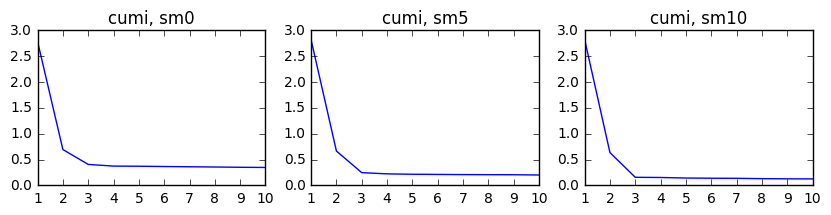

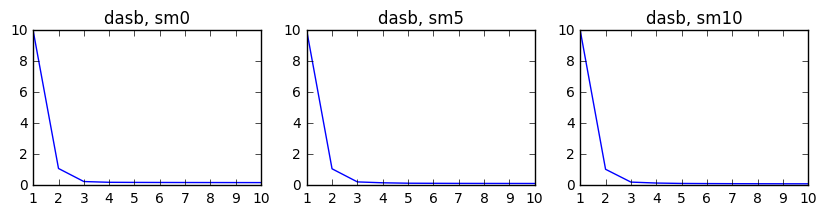

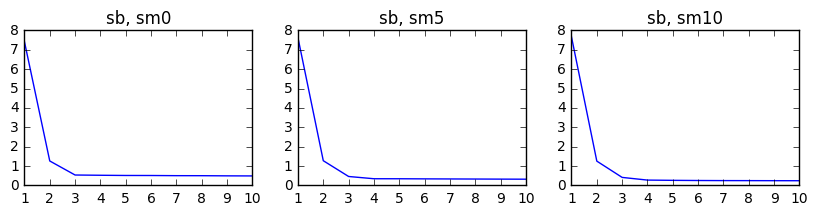

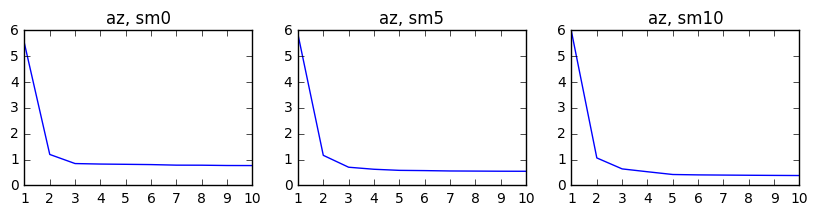

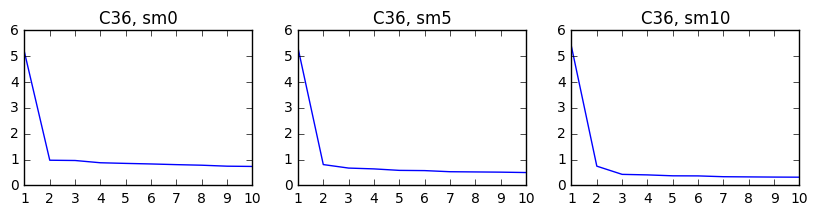

In [46]:
# Create surface maps of MFA weights and plot eigenvalue, for a range of smoothness levels

tracers=['cumi','dasb','sb','az','C36']
targ='fsaverage5'
smooth=['0','5','10']

Kmax=10 # Maximum number of components to consider
svd=TruncatedSVD(n_components=Kmax,algorithm='arpack')

plot_eigs=True
save_maps=True

for tracer in tracers:
    if plot_eigs:
        nplt=0
        plt.figure(figsize=(10,2))
    for sm in smooth:
        # Load the data
        preproc=np.load(MFA_preproc + '/' + tracer + '.' + targ + '.sm' + sm + '.npz')
        data=preproc['arr_0']
        eig1=preproc['arr_1']
        hemi_mask=preproc['arr_2'].item()
        N=len(data)

        # Divide all datasets by first eigenval
        for ns in np.arange(0,N):
            data[ns]=data[ns]/eig1[ns] # Consider multiplying by a large number before division to avoid numerical instabilities

        # Perform SVD
        svd.fit(np.transpose(np.hstack(data)))
        U=np.transpose(svd.components_)
        S=np.linalg.svd(np.hstack(data),full_matrices=False,compute_uv=False)
        if plot_eigs:
            nplt=nplt+1
            plt.subplot(1,len(smooth),nplt)
            plt.plot(np.arange(1,Kmax+1),S[0:Kmax])
            plt.title(tracer + ', sm' + sm)
            
        if save_maps: # Save weights out as surface overlay
            nprev=0
            nnext=0
            for hemi in hemi_type:        
                nprev=nnext
                nnext=nprev+sum(hemi_mask[hemi])
                wimg=np.zeros([1,len(hemi_mask[hemi]),1,Kmax])
                wimg[0,hemi_mask[hemi],0,:] = U[nprev:nnext,:]
                nib.save(Nifti1Image(wimg, np.eye(4)), MFA_data + '/' + tracer + 
                     '/MFA.weights.' + hemi + '.' + targ + '.sm' + sm + '.nii.gz')
                
    plt.show()

In [ ]:
# Compare components obtained with SVD and truncated SVD
# Here PCA is used as the gold standard (full, accurate decomposition)
# and truncated SVD is performed with some variations

from sklearn.decomposition import PCA

tracer='cumi'
preproc=np.load(MFA_data + '/' + tracer + '/preproc.fsaverage5.sm5.npz')
data=preproc['arr_0']
data=np.hstack(data) # Use whole dataset

Kmax=20
U,S,V=np.linalg.svd(data,full_matrices=False)

def print_corr(A,B,Kmax):
    for i in np.arange(0,Kmax):
        cc=np.zeros(Kmax)
        for j in np.arange(0,Kmax):
            cc[j]=abs(np.dot(np.transpose(A[:,i]),B[:,j]))
        print('Component ' + str(i+1) + ': %f' % np.max(cc))
    
# Trunk SVD from PCA
print('Truncated SVD with PCA')
pca=PCA(n_components=Kmax)
pca.fit(np.transpose(data))
print_corr(np.transpose(pca.components_),U,Kmax)

# Trunk SVD from TruncatedSVD with random the randomized algorithm (default)
print('\nTruncated SVD with randomized')
svd1=TruncatedSVD(n_components=Kmax)
svd1.fit(np.transpose(data))
print_corr(np.transpose(svd1.components_),U,Kmax)

# Trunk SVD from TruncatedSVD with ARPACK algorithm
print('\nTruncated SVD with ARPACK')
svd2=TruncatedSVD(n_components=Kmax,algorithm='arpack')
svd2.fit(np.transpose(data))
print_corr(np.transpose(svd2.components_),U,Kmax)

In [ ]:
# Perform bootstrap of the MFA components to obtain an estimate of each component at the vertice level
# The goal here is to identify components containing significant "structures", and keep those components

tracers=['cumi','dasb','sb','az','C36']
# tracers=['cumi']
targ='fsaverage5'
sm='5'

Niter=500 # Number of iterations (usually ~1000 or 10000)
Nupdate=50 # Number of iteration for verbose update
Kmax=10 # Maximum number of components to consider

conf=0.025

for tracer in tracers:
    
    # Load the data
    preproc=np.load(MFA_data + '/' + tracer + '/preproc.' + targ + '.sm' + sm + '.npz')
    data=preproc['arr_0']
    eig1=preproc['arr_1']
    N=data.shape[0]
    Nvert=data[0].shape[0]
    
    # Divide all datasets by first eigenval
    for ns in np.arange(0,N):
        data[ns]=data[ns]/eig1[ns] # Consider multiplying by a large number before division to avoid numerical instabilities
        
    svd=TruncatedSVD(n_components=Kmax,algorithm='arpack')
    svd.fit(np.transpose(np.hstack(data)))
    U=np.transpose(svd.components_)
    S=np.linalg.svd(np.hstack(data), full_matrices=False, compute_uv=False)
    
    Zboot=np.ndarray([Nvert,Niter,Kmax])
    Sboot=np.ndarray([Kmax,Niter])
    start_t = time.time()
    if (Nupdate>0):
        print('Processing ' + tracer)
    for ni in np.arange(0,Niter): # Will need to parallelize this

        if (Nupdate>0 and ni % Nupdate == 0):
            print('Iter ' + str(ni))    
        
        # Get indices for current fold
        ind=resample(np.arange(0,N),replace=True)
        
        # Perform SVD and compute
        svd.fit(np.transpose(np.hstack(data[ind])))
        src_ind,_,Uboot=balance_svd_components(U,np.transpose(svd.components_),return_balanced=True)
        Zboot[:,ni,:]=scale(Uboot)
        Sboot[:,ni]=np.linalg.svd(np.hstack(data[ind]), full_matrices=False, compute_uv=False)[src_ind]
            
    # Build 95% confidence interval and find if 0 is within the interval at each vertice
    sig=np.empty([Nvert,Kmax])
    for nk in np.arange(0,Kmax):
        Zboot[:,:,nk]=np.sort(Zboot[:,:,nk],axis=1)
        ind=Zboot[:,Niter-1,nk]>0
        nind=np.logical_not(ind)
        sig[ind,nk]=Zboot[ind,int(np.round(Zboot.shape[1]*conf)),nk]>0 # 0 is not in the lower tail
        sig[nind,nk]=Zboot[nind,int(np.round(Zboot.shape[1]*conf)),nk]<0 # 0 is not in the upper tail
                    
    # Save components and eigval
    np.savez(MFA_data + '/' + tracer + '/bootstrap.data.' +  targ +'.sm' + sm,Zboot,Sboot,sig)
    
    # Save out mean Z maps and significant vertices as surface overlays   
    nprev=0
    nnext=0
    for hemi in hemi_type:        
        nprev=nnext
        nnext=nprev+sum(hemi_mask[hemi])
        wimg=np.zeros([1,len(hemi_mask[hemi]),1,Kmax])
        wimg[0,hemi_mask[hemi],0,:] = Zboot.mean(axis=1)[nprev:nnext,:]
        save(Nifti1Image(wimg, np.eye(4)), MFA_data + '/' + tracer + 
             '/bootstrap.Zmean.' + hemi + '.' + targ + '.sm' + sm + '.nii.gz')
        wimg[0,hemi_mask[hemi],0,:] = sig[nprev:nnext,:]
        nib.save(Nifti1Image(wimg, np.eye(4)), MFA_data + '/' + tracer + 
             '/bootstrap.sig.' + hemi + '.' + targ + '.sm' + sm + '.nii.gz')
        

Processing cumi


C:\Program Files\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:177: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


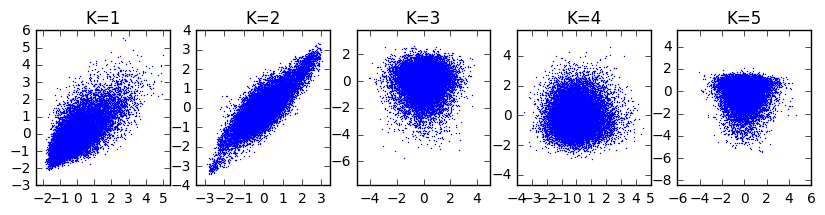

Processing dasb


C:\Program Files\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:160: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


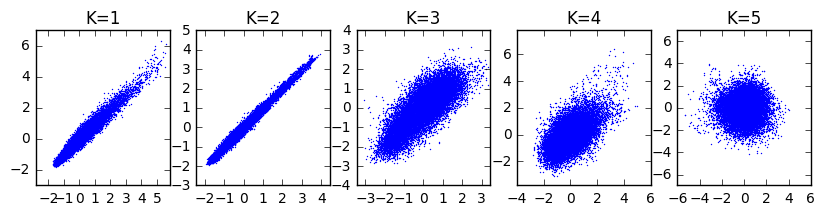

Processing sb


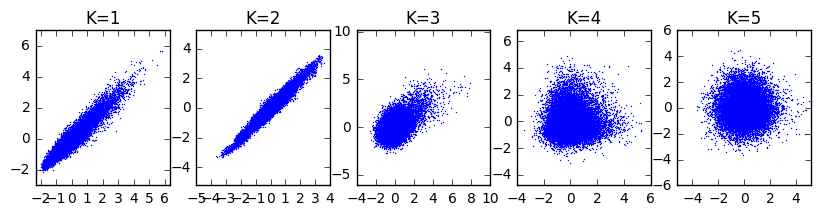

Processing az


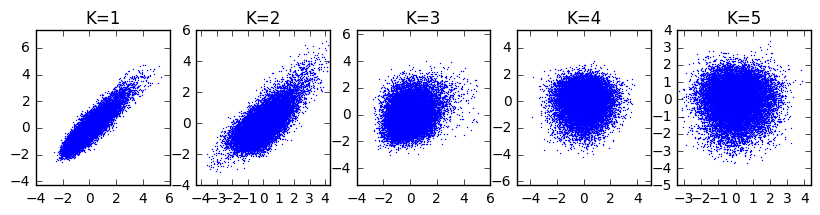

Processing C36


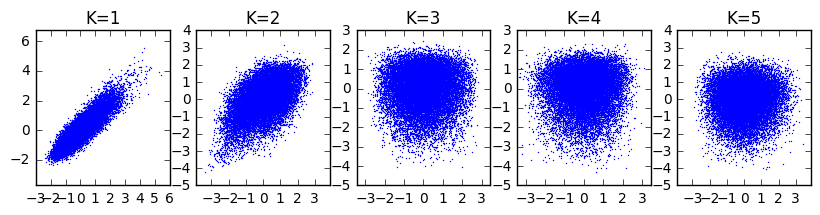

In [36]:
# Perform split-half evaluation the reproducibility of the MFA components

tracers=['cumi','dasb','sb','az','C36']
# tracers=['dasb']
targ='fsaverage5'
sm='5'

Niter=1 # Number of split-half iterations (usually ~1000 or 10000)
Kmax=5 # Maximum number of components to consider

plot_example=True
Nupdate=100

kf=KFold(n_splits=2,shuffle=True) # Split-half model
cc={}
cc_null={}
for tracer in tracers:
    
    # Load the data
    preproc=np.load(MFA_preproc + '/' + tracer + '.' + targ + '.sm' + sm + '.npz')
    data=preproc['arr_0']
    eig1=preproc['arr_1']
    N=data.shape[0]
    
    # Divide all datasets by first eigenval
    for ns in np.arange(0,N):
        data[ns]=data[ns]/eig1[ns] # Consider multiplying by a large number before division to avoid numerical instabilities
        
    svd=TruncatedSVD(n_components=Kmax,algorithm='arpack')    
    start_t = time.time()
    print('Processing ' + tracer)
    for ni in np.arange(0,Niter): # Will need to parallelize this

#         if (Nupdate>0 and ni % 100 == 0):
#             print('Iter ' + str(ni)            
        
        # Get indices for current fold
        split1,split2=kf.split(np.arange(0,N))
        
        # Perform SVD on split 1 & 2, separately
        svd.fit(np.transpose(np.hstack(data[split1[0]])))
        U1=scale(np.transpose(svd.components_))
        svd.fit(np.transpose(np.hstack(data[split2[0]])))
        U2=scale(np.transpose(svd.components_))
        [_,_,U2]=mu.balance_svd_components(U1,U2,return_balanced=True)
        
        plt.figure(figsize=(10,2))
        if plot_example:
            for nk in np.arange(0,Kmax):
                plt.subplot(1,Kmax,nk+1)
                plt.scatter(U1[:,nk],U2[:,nk],s=1,lw=0)
                plt.axis('equal')
                plt.title('K=' + str(nk+1))

            plt.show()

cumi


C:\Program Files\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:160: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\Program Files\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:177: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


cumi


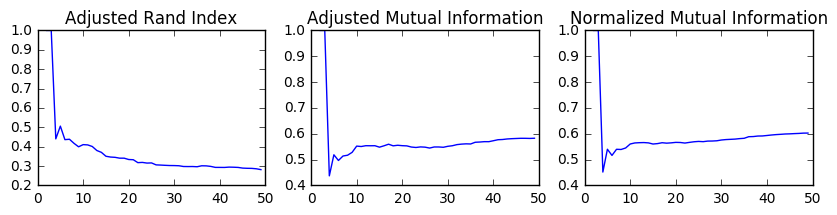

dasb
dasb


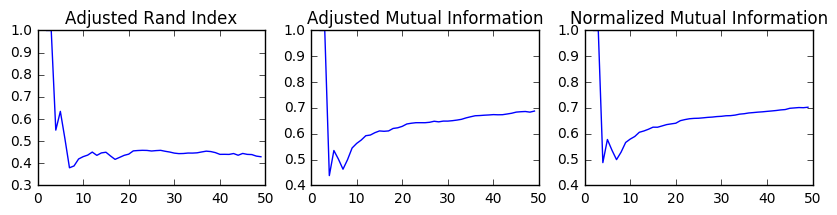

sb
sb


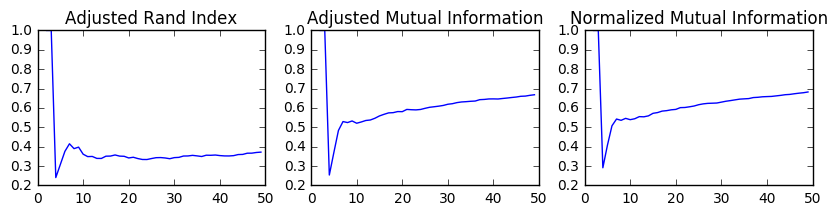

az
az


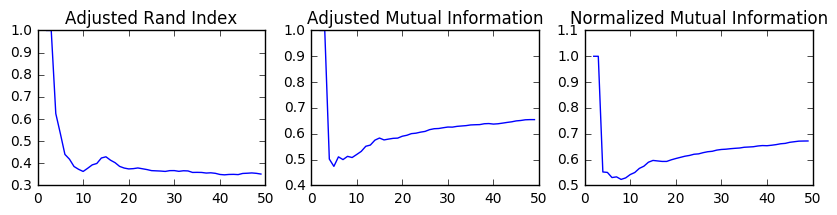

C36
C36


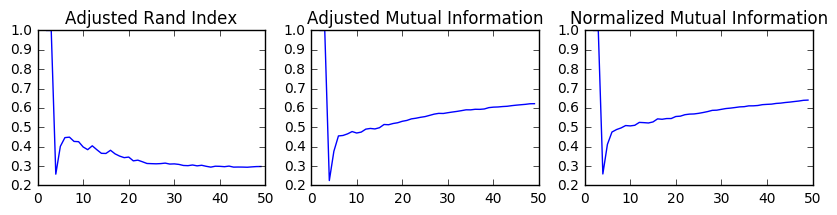

In [58]:
# Cluster BPnd maps using Ward's with spatial constraint
# Dimensionality is estimated based on stability metrics in split-half setting
# This will be useful to see if we gain anything knowledge from decomposing the dynamic data

tracers=['cumi','dasb','sb','az','C36']
# tracers=['cumi']
# hemi_type=['lh','rh']
hemi_type=['lh']
targ='fsaverage5'
sm='10'

dest=cluster_data + '/BPnd'
mu.assert_dir(dest)
    
convert=False  
cluster=True
whole_dataset=False

# Split-half parameters
split_half=True
Krange=np.arange(2,50,1)
kf=KFold(n_splits=2,shuffle=True)
Niter=10
plot_metrics=True

# Perform Ward clustering on BPnd data
for tracer in tracers:
    
    print(tracer)
    
    surf_dest=dest + '/' + tracer    
    mu.assert_dir(surf_dest)
    
    # If BPnd was not preprocessed (e.g. fsaverage5), do it here
    if convert:        
        log_dest=surf_dest + '/log'
        mu.assert_dir(log_dest)
        hemi_mask={}
        bpnd=np.ndarray([len(hemi_type)],dtype=object)
        nh=0
        for hemi in hemi_type:
            # Convert BPnd from fsaverage to target
            sval=('/data1/vbeliveau/atlas/analyses/bmax_maps/data.nopvc.surf/' + 
                tracer + '.bpnd.mrtm2.nopvc.fsaverage.' + hemi + '.sm' +  sm + '.nii.gz')
            tval=surf_dest + '/bpnd.mrtm2.nopvc.' + targ + '.' + hemi + '.sm' + sm + '.nii.gz'

            log_file=open(log_dest + '/mri_surf2surf.' + hemi +'.log','w')
            p=Popen(['mri_surf2surf','--srcsubject','fsaverage','--trgsubject',targ,
                    '--srchemi',hemi,'--trghemi',hemi,'--sval',sval,'--tval',tval], stdout=log_file, stderr=log_file)
            p.communicate()
            log_file.close()
                                            
    if cluster: # Estimate cluster number using stability metrics in split-half
        
        for hemi in hemi_type:
            
            img=nib.load(surf_dest + '/bpnd.mrtm2.nopvc.' + targ + '.' + hemi + '.sm' + sm + '.nii.gz')
            data=np.squeeze(img.get_data())
            N=data.shape[1]
            Nvert=data.shape[0]
            hemi_mask=np.sum(data,axis=1)>0

            # Import adjacency matrix and only keep elements in surface mask
            A=sio.loadmat(cluster_code + '/freesurfer_adjacency/adjacency.' + targ + '.' + hemi + '.mat')
            Amask=A['A'][np.ix_(hemi_mask,hemi_mask)]

            # Scale the data
            data_scaled=scale(data[hemi_mask,:])
            
            # Cluster the whole dataset for a range of K
            if whole_dataset:
                ward_labels=np.zeros([1,Nvert,1,len(Krange)])
                for nk in np.arange(0,len(Krange)):
                    mdl=AgglomerativeClustering(n_clusters=Krange[nk], connectivity=Amask,linkage='ward')
                    mdl.fit(data_scaled)
                    ward_labels[0,hemi_mask,0,nk]=mdl.labels_+1

                # Save the clustering out as surface overlay
                nib.save(Nifti1Image(ward_labels, np.eye(4)), 
                         surf_dest + '/ward.' + targ + '.' + hemi + '.sm' + sm + '.nii.gz')

            # Evaluate clustering stability for a range of K
            if split_half:
                ars=np.empty([Niter,len(Krange)])
                ami=np.empty([Niter,len(Krange)])
                mdl1=AgglomerativeClustering(compute_full_tree=True, connectivity=Amask,linkage='ward')
                mdl2=AgglomerativeClustering(compute_full_tree=True, connectivity=Amask,linkage='ward')
                for ni in np.arange(0,Niter):
                    # Fit data
                    split1,split2=kf.split(np.arange(0,N))                    
                    mdl1.fit(data_scaled[:,split1[0]])
                    mdl2.fit(data_scaled[:,split2[0]])
                    
                    for nk in np.arange(0,len(Krange)):
                        # Cut trees
                        # NOTE: labels start at 0, so add one to distinguish from medial wall
                        labels1=_hc_cut(nk,mdl1.children_,mdl1.n_leaves_)+1 
                        labels2=_hc_cut(nk,mdl2.children_,mdl2.n_leaves_)+1
                        
                        # Compute metrics
                        ars[ni,nk]=metrics.adjusted_rand_score(labels1, labels2)
                        ami[ni,nk]=metrics.adjusted_mutual_info_score(labels1, labels2)
                                                
#                 np.savez(surf_dest + '/ward.metrics.' + targ + '.' + hemi + '.sm' + sm,ars,ami,nmi,Krange)

                if plot_metrics:
                    print(tracer)
                    plt.figure(figsize=(8,2))
                    plt.subplot(1,2,1)
                    plt.plot(Krange,ars.mean(axis=0))
                    plt.title('Adjusted Rand Index')
                    plt.subplot(1,2,2)
                    plt.plot(Krange,ami.mean(axis=0))
                    plt.title('Adjusted Mutual Information')
                    plt.show()

cumi


C:\Program Files\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:160: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\Program Files\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:177: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


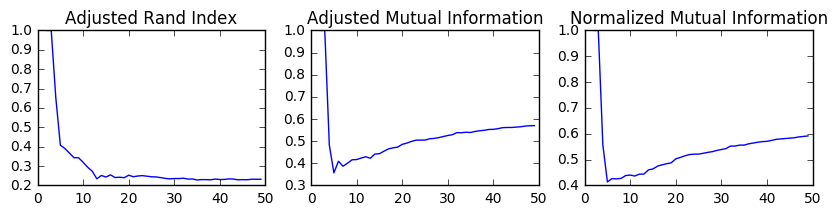

dasb


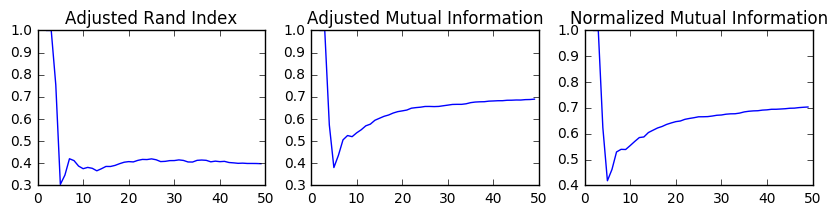

sb


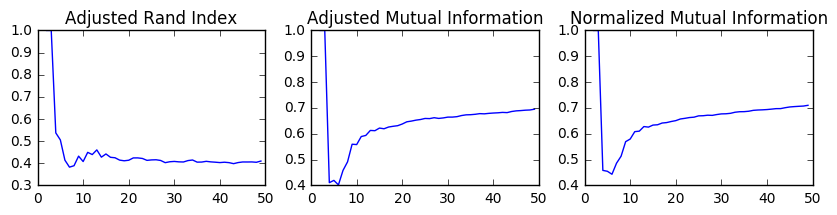

az


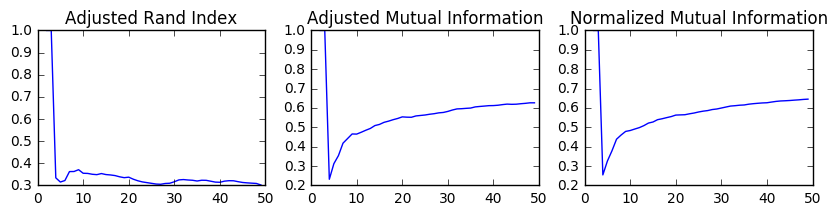

C36


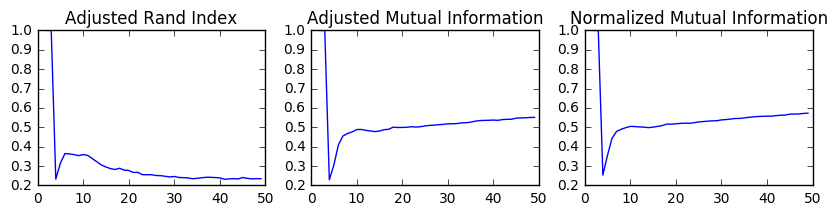

In [59]:
# Cluster MFA components using Ward's with spatial constraint
# Dimensionality is estimated based on stability metrics in split-half setting

tracers=['cumi','dasb','sb','az','C36']
# tracers=['cumi']
# hemi_type=['lh','rh']
hemi_type=['lh']
targ='fsaverage5'
sm='10'

Kopt={'cumi': 2, 'dasb': 3,'sb': 2, 'az': 2,'C36': 1}

dest=cluster_data + '/MFA'
mu.assert_dir(dest)
    
convert=False  
cluster=True
whole_dataset=False

# Split-half parameters
split_half=True
Krange=np.arange(2,50,1)
kf=KFold(n_splits=2,shuffle=True)
Niter=10
plot_metrics=True

# Perform Ward clustering on MFA components
for tracer in tracers:

    print(tracer)
    
    surf_dest=dest + '/' + tracer    
    mu.assert_dir(surf_dest)

    # Define SVD model
    svd=TruncatedSVD(n_components=Kopt[tracer],algorithm='arpack')
    
    # Load the data
    preproc=np.load(MFA_preproc + '/' +  tracer + '.' + targ + '.sm' + sm + '.npz')
    data=preproc['arr_0']
    eig1=preproc['arr_1']
    hemi_mask=preproc['arr_2'].item()
    N=data.shape[0]
    Nvert=data[0].shape[0]

    # Divide all datasets by first eigenval
    for ns in np.arange(0,N):
        data[ns]=data[ns]/eig1[ns] # Consider multiplying by a large number before division to avoid numerical instabilities
        
    # Preload adjacency matrix (might need to modify this if they can't be held in memory)
    Amask={}; mdl1={}; mdl2={}; ars={}; ami={}
    for hemi in hemi_type:
        # Import appropriate adjacency matrix
        A=sio.loadmat(cluster_code + '/freesurfer_adjacency/adjacency.' + targ + '.' + hemi + '.mat')
        Amask[hemi]=A['A'][np.ix_(hemi_mask[hemi],hemi_mask[hemi])]
        # Clustering models & comparison metrics
        mdl1[hemi]=AgglomerativeClustering(compute_full_tree=True, connectivity=Amask[hemi],linkage='ward')
        mdl2[hemi]=AgglomerativeClustering(compute_full_tree=True, connectivity=Amask[hemi],linkage='ward')
        ars[hemi]=np.empty([Niter,len(Krange)])
        ami[hemi]=np.empty([Niter,len(Krange)])
        nmi[hemi]=np.empty([Niter,len(Krange)])

    for ni in np.arange(0,Niter):

        # Get optimal (Kopt) MFA components (scaled)
        split1,split2=kf.split(np.arange(0,N))
        svd.fit(np.transpose(np.hstack(data[split1[0]])))
        data_scaled1=scale(np.transpose(svd.components_))
        svd.fit(np.transpose(np.hstack(data[split2[0]])))
        data_scaled2=scale(np.transpose(svd.components_))

        nprev=0
        nnext=0
        for hemi in hemi_type:        
            nprev=nnext
            nnext=nprev+sum(hemi_mask[hemi])

            # Fit data
            mdl1[hemi].fit(data_scaled1[nprev:nnext,:])
            mdl2[hemi].fit(data_scaled2[nprev:nnext,:])

            for nk in np.arange(0,len(Krange)):
                    # Cut trees
                    # NOTE: labels start at 0, so add one to distinguish from medial wall
                    labels1=_hc_cut(nk,mdl1[hemi].children_,mdl1[hemi].n_leaves_)+1 
                    labels2=_hc_cut(nk,mdl2[hemi].children_,mdl2[hemi].n_leaves_)+1

                    # Compute metrics
                    ars[hemi][ni,nk]=metrics.adjusted_rand_score(labels1, labels2)
                    ami[hemi][ni,nk]=metrics.adjusted_mutual_info_score(labels1, labels2)

#                 np.savez(surf_dest + '/ward.metrics.' + targ + '.' + hemi + '.sm' + sm,ars,ami,nmi,Krange)

    for hemi in hemi_type:
        if plot_metrics:
            plt.figure(figsize=(8,2))
            plt.subplot(1,2,1)
            plt.plot(Krange,ars[hemi].mean(axis=0))
            plt.title('Adjusted Rand Index')
            plt.subplot(1,2,2)
            plt.plot(Krange,ami[hemi].mean(axis=0))
            plt.title('Adjusted Mutual Information')
            plt.show()

In [171]:
vertices,position=mu.freesurfer_read_surf('freesurfer_adjacency/lh.pial',verbose=True)

Reading 20480 faces and 10242 vertices.


In [235]:
# personal functions
from importlib import reload
import myutils as mu
reload(mu)

<module 'myutils' from 'C:\\Users\\vbeliveau\\Documents\\GitHub\\5HT_clustering\\myutils.py'>

In [236]:
N,position=mu.build_neighborhood_matrix('freesurfer_adjacency/lh.pial')
img=nib.load(cluster_data + '/BPnd/cumi/bpnd.mrtm2.nopvc.fsaverage5.lh.sm10.nii.gz')
data=np.squeeze(img.get_data()).mean(axis=1)

In [237]:
gradvec=mu.build_surface_gradient_matrix(data,'freesurfer_adjacency/lh.pial')

In [239]:
gradvec[0:10,:]

array([[ 0.00258587,  0.01581592,  0.00302409],
       [ 0.00517835,  0.00288561,  0.00155129],
       [-0.05445941,  0.00955638,  0.07999294],
       [ 0.00869777, -0.00861112,  0.009769  ],
       [ 0.01082717, -0.00357243, -0.0235927 ],
       [ 0.00500523,  0.00027169, -0.00612684],
       [-0.00808609, -0.00382284,  0.02938662],
       [ 0.01242853,  0.04103264, -0.01678207],
       [ 0.        ,  0.        ,  0.        ],
       [-0.03902667, -0.08425296,  0.01860336]])